In [1363]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import itertools
import scipy
import time

### Original model

Below is an implementation of the original model, with the sole modification that initial opinions  
can take any value between 0 and 1, to reflect the case where a population is not initially polarized.

In [1466]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=0.4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = np.random.uniform(0, 1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            cmap='RdBu',
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if np.random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = np.random.choice(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = list(self.graph.edges)[np.random.choice((range(len(self.graph.edges))))]
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

When gamma (coefficient of "pickiness" or "intolerance")is set takes low values, the population
tends to ammalgamate together with a uniform opinion.

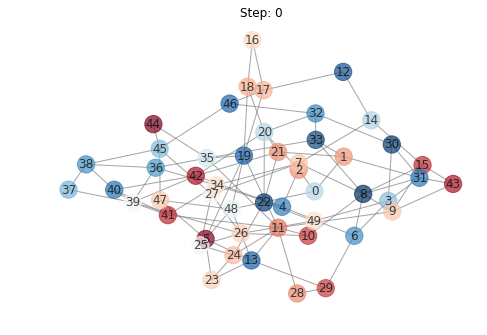

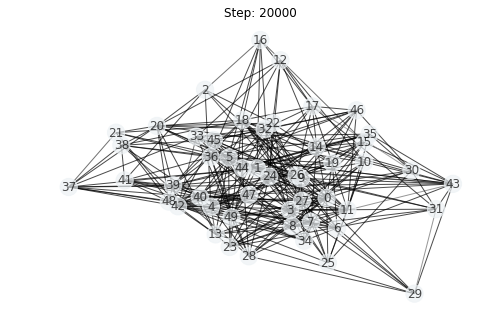

In [1334]:
sim = SocialDynamicsSimulation(beta=0.3, gamma=2)
plt.figure()
sim.observe()

for i in range(20000):
    sim.update()

plt.figure()
sim.observe()

plt.show()

Given high values for gamma, the community will split into two main poles, with few or none remaining ties
between them. This is even exacerbated when starting values are 0 and 1.

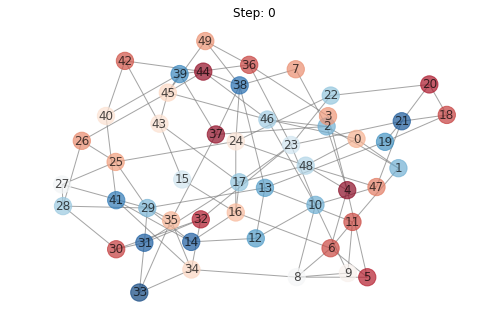

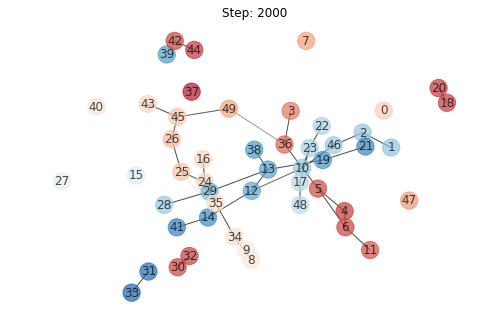

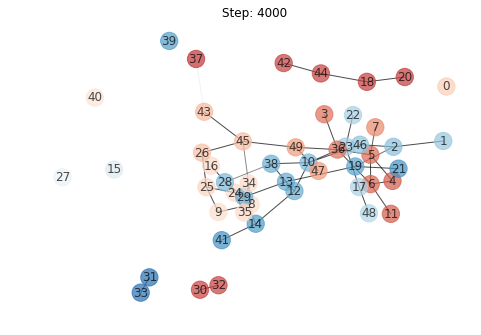

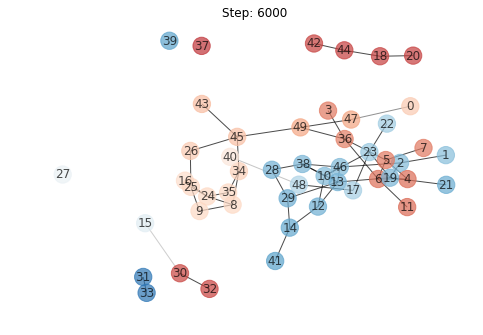

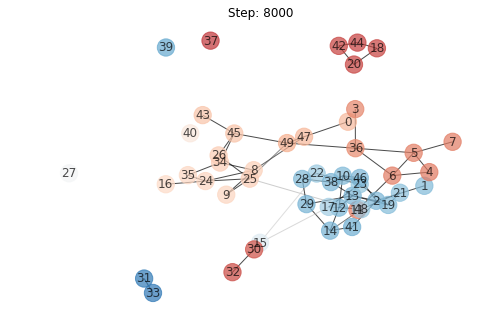

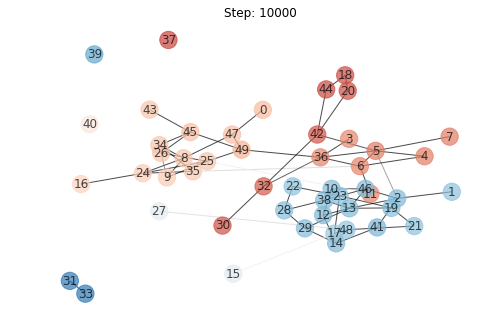

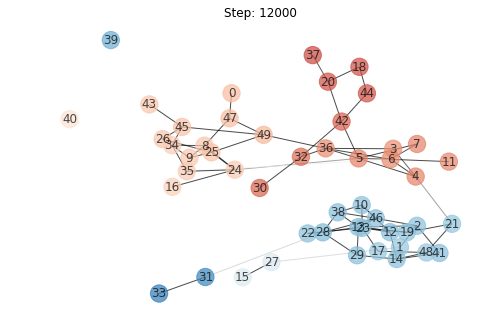

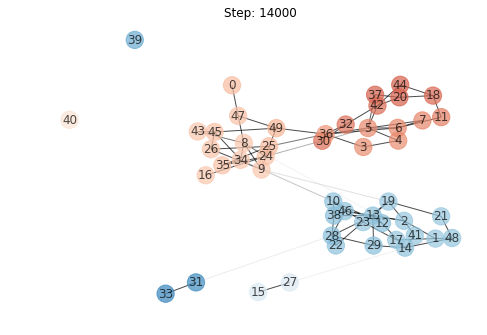

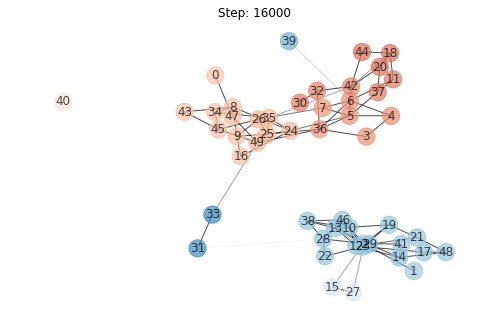

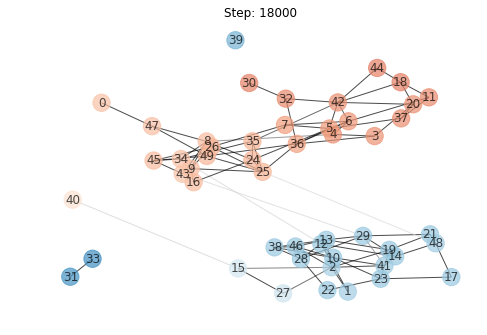

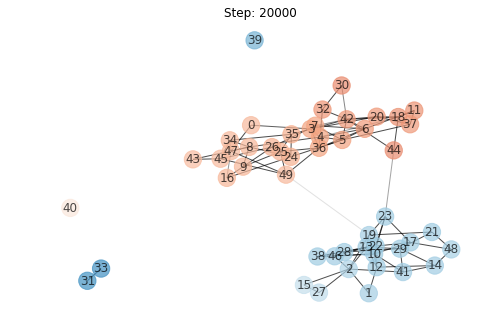

In [333]:
sim = SocialDynamicsSimulation(gamma=10)
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()

plt.show()

I implemented the following extensions to the model

* Multiple opinions.


* The opinion vector is sampled from a truncated (0,1) trivariate normal distribution to model the observed correlation   between political opinions (e.g. let 0 be conservative opinions and 1 be liberal views about each topic). The multivariate distribution takes a single parameter "correlated" (r). The  
 sampling assumes the three opinions  have identical standard deviations, and the covariance between each  pair is calculated from the pearson's  
 r coefficient given by the user. For all simulations performed I will use a correlation of 0.5, an arbitrary value I expect to represent the level of polarization present in the United States. The mean of the distribution is [.5 .5 .5]T.
 
* An acceptance process prior to engagement in conversation. Probability of acceptance is given by p = 0.1**(d(i,j)/delta). Delta is a simulation parameter associated with the acceptance of global differences. 

* If two individuals accept to talk, they will only do so in the topic of least disagreement. This is intended to model the phenomenon of two individuals resorting to agreeability to "break the ice" with someone who might be otherwise very different to them.

### Extended model

In [1493]:
class MultivarSocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.075, beta=0.3, gamma=4, delta=1, 
                 correlated = 0.5, p_add = 0.005, only_most_agreed=False, normal_sampling = True):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
              
            
            delta (float)
            
            correlated (float) [0-1]
            
            p_add (float) [0-1]
            
            only_most_agreed (boolean)
            
            normal_sampling (boolean)
              
              
              
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.correlated = correlated
        self.p_add = p_add
        self.only_most_agreed = only_most_agreed
        self.normal_sampling = normal_sampling
    
    def sample_opinions(self):
        #opinions are sampled according to the following trivariate normal distribution,
        #
        
        #multivariate mean (of each opinion)
        meanm = [0.5,0.5,0.5]
        
        #standard deviation of each opinion
        cov_jj = 0.25
        
        #covariance between each pair of opinions
        cov_ij = cov_jj**2 * self.correlated
        
        #covariance matrix
        covm = np.array([[cov_jj,cov_ij,cov_ij],
                        [cov_ij,cov_jj,cov_ij],
                        [cov_ij,cov_ij,cov_jj]])
        
        
        p = np.array([-1,-1,-1])
        #truncation by rejection.
        while np.any(p<0) or np.any(p>1):
            p = np.random.multivariate_normal(mean=[0.5,0.5,0.5],cov=covm,size=1)[0]
        
        return p
        
        
    
    def initialize(self):
#         '''
#         Initialize the simulation with a random graph, with random 0 or 1
#         opinions assigned to all nodes and initial edge weights of 0.5.
#         '''
        
        # for local analysis, start the graph as K2
        if self.network_size == 2:
            self.graph = nx.complete_graph(n=2)
        
        # otherwise, set the initial graph as a small world network
        elif self.network_size > 2:
            self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
        
        # all weights are initialized as 0.5
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        
        
        #decide method of sampling opinions: normally or discretely from [0,1] 
            
        if self.normal_sampling:
            self.graph.nodes[node]['opinion'] = self.sample_opinions()
        else:
            for node in self.graph.nodes:
                self.graph.nodes[node]['opinion'] = np.random.randint(0,2,3)
        
        
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0


        
    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=10)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            #cmap='RdBu',
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
            #alpha=0.7, vmin=0, vmax=1)
        
        if self.network_size == 2:
            opinions = [self.graph.nodes[n]['opinion'] for n in self.graph.nodes]
            plt.title('Step: ' + str(self.step) + '\n' + 'Euclidean distance between opinions: ' + str(np.linalg.norm(opinions[1] - opinions[0])))
        elif self.network_size > 2:
            plt.title('Step: ' + str(self.step) + '\n' + 'Dispersion: ' + str(self.dispersion()))
        else:
            raise 'Network Size error'

            
    def observe_custom(self, ax=plt.gca(), layout='spring'):
        '''
        Draw the state of the network with custom axis or layout.
        
        ax (matplotlib Axis) : axis 
        layout (string) : layout mode for network nodes
        
        '''
        if layout == 'spring':
            self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=25)
        elif layout == 'shell':
            self.layout = nx.shell_layout(self.graph)
        elif layout == 'spectral':
            self.layout = nx.spectral_layout(self.graph)
        elif layout == 'circular':
            self.layout = nx.circular_layout(self.graph)
        else:
            self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        #plt.clf()
        nx.draw_networkx(
            self.graph, pos=self.layout, with_labels=True, ax=ax,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            #cmap='RdBu',
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
            #alpha=0.7, vmin=0, vmax=1)
        
        if self.network_size == 2:
            opinions = [self.graph.nodes[n]['opinion'] for n in self.graph.nodes]
            ax.set_title('Step: ' + str(self.step) + '\n' + 'Euclidean distance between opinions: ' + str(np.linalg.norm(opinions[1] - opinions[0])))
        elif self.network_size > 2:
            ax.set_title('Step: ' + str(self.step) + '\n' + 'Dispersion: ' + str(self.dispersion()))
        else:
            raise 'Network Size error'
        
        ax.axis('off')
        
            
    def dispersion(self):
        covdet = np.linalg.det(np.cov(np.array([self.graph.nodes[x]['opinion'] for x in self.graph.nodes]), rowvar=False))
        return math.log(self.network_size,1/covdet)
    
    def len_out_largest_comp(self):
        return self.network_size - len(max(nx.connected_component_subgraphs(self.graph), key=len))
    
    
    def in_large_conn_component(self):
        return sum([len(g) for g in nx.connected_component_subgraphs(self.graph) if len(g) > 3])/self.network_size
    
    def average_degree(self):
        return 2*nx.number_of_edges(self.graph)/nx.number_of_nodes(self.graph)
    
    def n_large_connected_components(self):
        return len([c for c in nx.connected_components(sim.graph) if len(c) > 3])
    
    def update(self):
        if np.random.uniform(0, 1) < self.p_add:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = np.random.choice(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            
            try: # skip if no edges left
                edge = list(self.graph.edges)[np.random.choice((range(len(self.graph.edges))))]


                weight = self.graph.edges[edge]['weight']
                opinions = [self.graph.nodes[n]['opinion'] for n in edge]

                opinions_difference = opinions[1] - opinions[0]
                most_agreed = np.argmin(abs(opinions[1] - opinions[0]))



                opinions_distance = np.linalg.norm(opinions[1] - opinions[0])



                p_acceptance = 0.1**(opinions_distance/self.delta)


                if np.random.random() < p_acceptance:

                    for i in [0, 1]:
                        if self.only_most_agreed:
                            delta_opinion = np.zeros(3)
                            delta_opinion[most_agreed] = opinions[1-i][most_agreed] - opinions[i][most_agreed]
                        else:
                            delta_opinion = opinions[1-i] - opinions[i]

                        self.graph.nodes[edge[i]]['opinion'] = (
                            opinions[i] + self.alpha * weight * delta_opinion)
                    self.graph.edges[edge]['weight'] = (
                        weight +
                        self.beta * weight * (1-weight) *
                        (1 - self.gamma * opinions_distance/np.sqrt(3)))
                    # Remove very weak connections
                    if self.graph.edges[edge]['weight'] < 0.05:
                        self.graph.remove_edge(*edge)

                else:
                    #pass
                    self.graph.edges[edge]['weight'] = 0.9*weight #- (1-weight)*0.25
        
            except:
                pass #print('Warning: No edges left! Antisocial behavior detected')
        self.step += 1


### Local Analysis: Testing prediction of critical point from Vector field plot

alpha = 0.075, beta=0.3, gamma=4.5,
∆o_3 = 0.63, w = 0.9

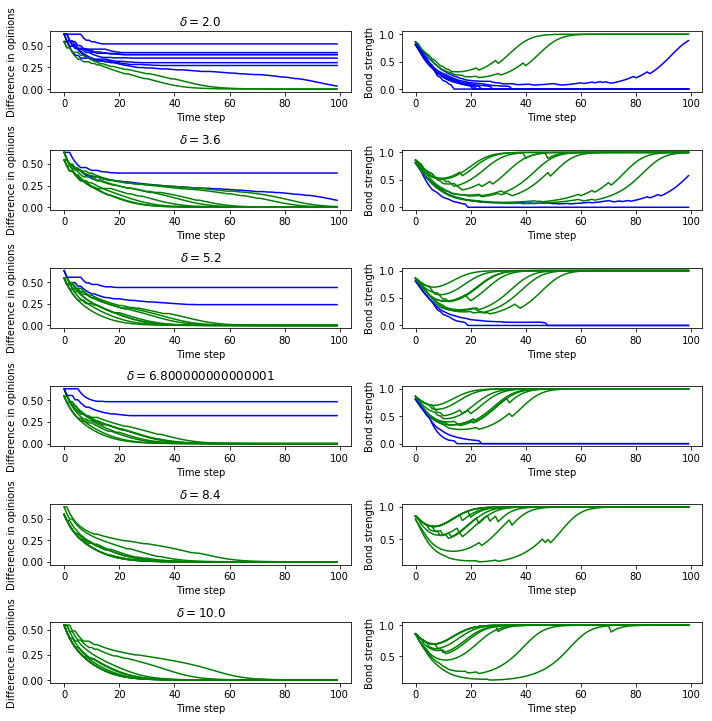

As expected, for this set of parameters and initial conditions there is a critical point between 7.5 and 10


In [1173]:
deltas = np.linspace(2,10,6)
fig, axes = plt.subplots(6,2, figsize=(10,10))


for idx,delta in enumerate(deltas):
    for r in range(10):
        opinion_evo = []
        bond_evo = []

        sim = MultivarSocialDynamicsSimulation(network_size=2, alpha=0.075, beta=0.3, gamma=4.5,delta=delta,correlated = 0.4, p_add = 0)
        sim.initialize()

        sim.graph.edges[0,1]['weight'] = 0.9
        sim.graph.nodes[0]['opinion'] = np.array([0,0,1])
        sim.graph.nodes[1]['opinion'] = np.array([0.5,0.5,1-0.6333])

        for i in range(100):
            sim.update()
            try:
                bond_evo.append(sim.graph.edges[0,1]['weight'])
            except:
                bond_evo.append(0)
            opinion_evo.append(abs(sim.graph.nodes[0]['opinion'][2]-sim.graph.nodes[1]['opinion'][2]))

        axes[idx,0].plot(range(100),opinion_evo,
                        color = 'green' if bond_evo[-1] > 0.9 else 'blue')
        axes[idx,1].plot(range(100),bond_evo,
                                     color = 'green' if bond_evo[-1] > 0.9 else 'blue')
        
        axes[idx,0].set_title(r'$\delta={}$'.format(delta))
        axes[idx,0].set_xlabel('Time step')
        axes[idx,1].set_xlabel('Time step')
        
        axes[idx,0].set_ylabel('Difference in opinions')
        axes[idx,1].set_ylabel('Bond strength')

plt.tight_layout()

plt.show()

print('As expected, for this set of parameters and initial conditions there is a critical point between 7.5 and 10')


## Simulation analysis

alpha=0.075, beta=0.3, gamma=7.89,delta=7.5,correlated = 0.4, p_add = 0.001

### Question 1: Does correlation between variables affect final dispersion of opinions?

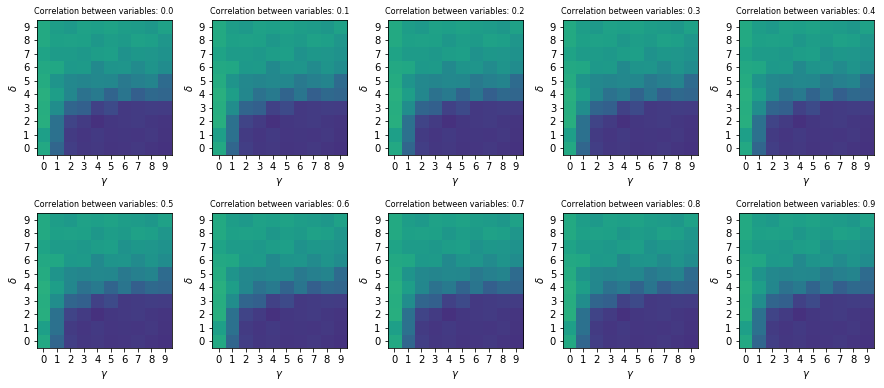

In [910]:
gammas = np.linspace(0,10,10)
deltas = np.linspace(0,10,10)
correl = np.linspace(0,0.9,10)

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))

fig, axes = plt.subplots(2,5,figsize=(15,10))

for k,ax in enumerate(axes.flatten()):
    start = time.time()
    for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = SocialDynamicsSimulation(gamma=g,delta=d,correlated=correl[k])
            sim.initialize()
            for _ in range(10000):
                sim.update()
            dispersions[i,j] = sim.dispersion()
    
    
    ax.imshow(dispersions,origin='lower',vmin=0,vmax=0.8)
    ax.set_xticks(range(0,10,1))
    ax.set_yticks(range(0,10,1))
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(r'$\delta$')
    ax.set_title('Correlation between variables: {}'.format(str(correl[k])[:3]),fontsize=8)

#plt.tight_layout()
plt.subplots_adjust(hspace=-0.45,wspace=0.3)#0.01,0.4,0.1,0.5)
#plt.colorbar(plt.imshow(dispersions,vmin=0,vmax=0.8))
plt.show()

Answer: No.
    
### Question 2: How do the values of gamma and delta affect the evolution of opinions and the topology of the network?

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars


5.0% done
10.% done
15.% done
20.% done
25.% done
30.% done
35.% done
40.% done
45.% done
50.% done
55.% done
60.% done
65.% done
70.% done
75.% done
80.% done
85.% done
90.% done
95.% done
100% done


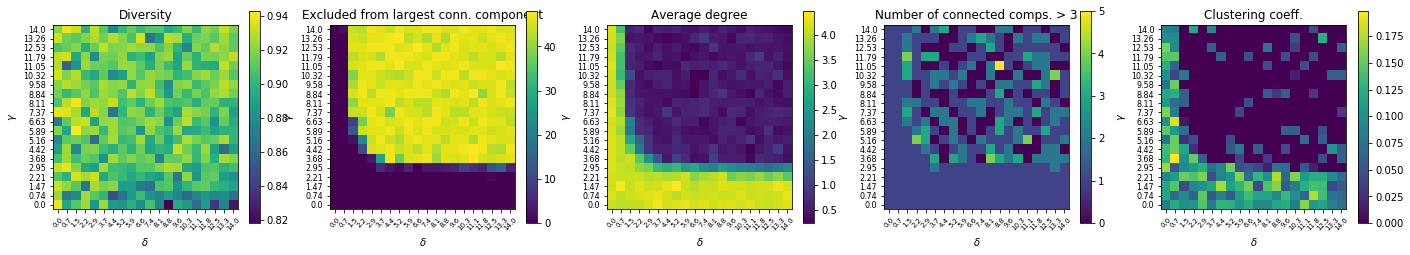

In [1346]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
correl=0.9

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
clus = np.zeros((gammas.shape[0],deltas.shape[0]))



for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,only_most_agreed= True, network_size=50)
            sim.initialize()
            for _ in range(1000):
                sim.update()
                
            try:
                dispersions[i,j] = sim.dispersion()
            except:
                dispersions[i,j] = 0
            
            largest_components[i,j] = sim.len_out_largest_comp()
            avgdegs[i,j] = sim.average_degree()
            nlcs[i,j] = sim.n_large_connected_components()
            clus[i,j] = nx.average_clustering(sim.graph)
        
        print('{}% done'.format(str((i+1)*100/len(gammas))[:3]))

metrics = np.array([dispersions,largest_components,avgdegs,nlcs,clus])
titles = ['Diversity','Excluded from largest conn. component', 'Average degree', 'Number of connected comps. > 3', 'Clustering coeff.']
# imshows = ['','','','','']

fig, axes = plt.subplots(1,5,figsize=(24,26))
for i,ax in enumerate(axes.flatten()[:5]):
    imshows[i] = ax.imshow(metrics[i],origin='lower')
    ax.set_xticks(range(len(deltas)))
    ax.set_yticks(range(len(gammas)))
    
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\gamma$')
    
    ax.set_title(titles[i])
    
    ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
    ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
for i,ax in enumerate(axes.flatten()):
    plt.colorbar(imshows[i], ax=axes[i],shrink=0.15)

# #plt.tight_layout()
plt.show()





Answer: With the tested parameters, there seem to be two attractors. The state shown in the upper right of the last 4 subfigures represents the state of almost no bonds existing between individuals. The state below and on the extreme left of these figures represents the state of a netwoerk where all individuals are part of the largest connected component, with various levels of clustering. Diversity of opinions seems to be uncorrelated with either parameter, although the highest levels of diversity seem to arise within the basin of the top-right attractor, and the lowest levels occur with gamma < 1.


### Question 3: Does the most agreed criterion prevent opinions from becoming too narrow or too diverse?

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in double_scalars


5.0% done
10.% done
15.% done
20.% done
25.% done
30.% done
35.% done
40.% done
45.% done
50.% done
55.% done
60.% done
65.% done
70.% done
75.% done
80.% done
85.% done
90.% done
95.% done
100% done


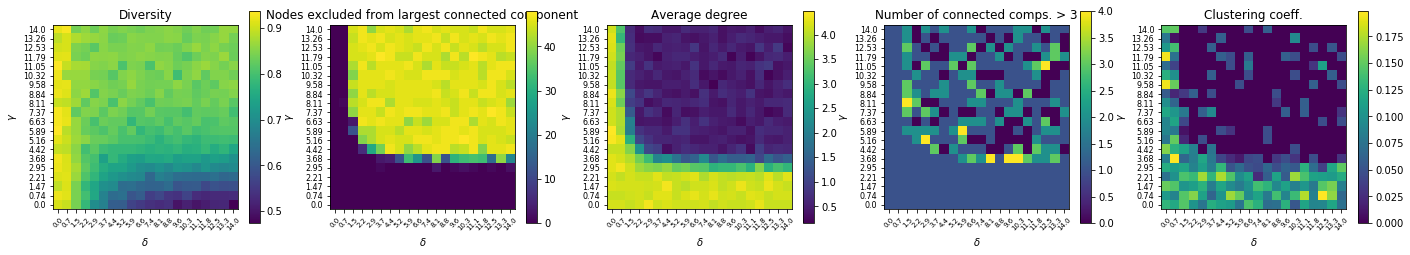

In [1345]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
correl=0.9

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
clus = np.zeros((gammas.shape[0],deltas.shape[0]))



for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,network_size=50)
            sim.initialize()
            for _ in range(1000):
                sim.update()
                
            try:
                dispersions[i,j] = sim.dispersion()
            except:
                dispersions[i,j] = 0
            
            largest_components[i,j] = sim.len_out_largest_comp()
            avgdegs[i,j] = sim.average_degree()
            nlcs[i,j] = sim.n_large_connected_components()
            clus[i,j] = nx.average_clustering(sim.graph)
        
        print('{}% done'.format(str((i+1)*100/len(gammas))[:3]))

metrics = np.array([dispersions,largest_components,avgdegs,nlcs,clus])
titles = ['Diversity','Excluded from largest conn. component', 'Average degree', 'Number of connected comps. > 3', 'Clustering coeff.']
# imshows = ['','','','','']

fig, axes = plt.subplots(1,5,figsize=(24,26))
for i,ax in enumerate(axes.flatten()[:5]):
    imshows[i] = ax.imshow(metrics[i],origin='lower')
    
    ax.set_xticks(range(len(deltas)))
    ax.set_yticks(range(len(gammas)))
    
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\gamma$')
    
    ax.set_title(titles[i])
    
    ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
    ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
for i,ax in enumerate(axes.flatten()):
    plt.colorbar(imshows[i], ax=axes[i],shrink=0.15)

# #plt.tight_layout()
plt.show()




Answer: Yes. Restricting discussion to the least disagreed topic maintains opinion diversity when individuals are very tolerant (by not letting their opinions' on other topics be affected when there is serious disagreement about them) and dampens it when they are too picky (by ensuring that people talk to people they disagree with).

### Question 4: Are initial conditions relevant for the determination of the phase portrait?
To answer this, I will run the simulation as in the original model, where each opinion is initialized as either 0 or 1.

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars


5.0% done
10.% done
15.% done
20.% done
25.% done
30.% done
35.% done
40.% done
45.% done
50.% done
55.% done
60.% done
65.% done
70.% done
75.% done
80.% done
85.% done
90.% done
95.% done
100% done


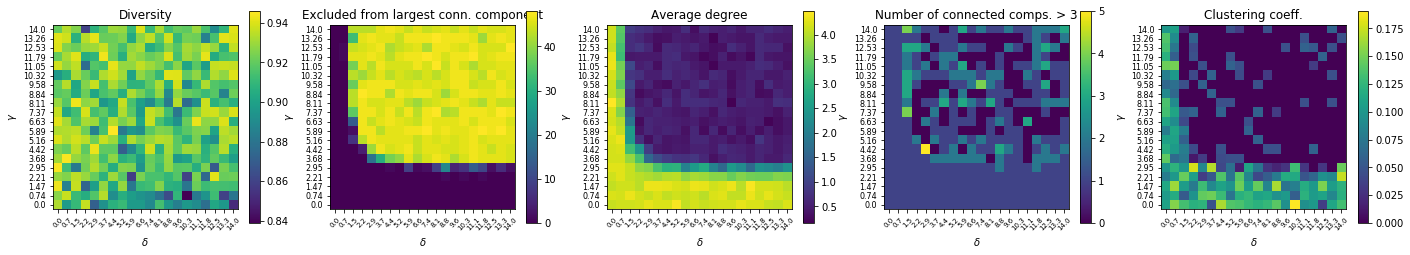

In [1347]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
correl=0.9

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
clus = np.zeros((gammas.shape[0],deltas.shape[0]))



for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,
                                                   network_size=50, only_most_agreed = True,
                                                   normal_sampling = False)
            sim.initialize()
            for _ in range(1000):
                sim.update()
                
            try:
                dispersions[i,j] = sim.dispersion()
            except:
                dispersions[i,j] = 0
            
            largest_components[i,j] = sim.len_out_largest_comp()
            avgdegs[i,j] = sim.average_degree()
            nlcs[i,j] = sim.n_large_connected_components()
            clus[i,j] = nx.average_clustering(sim.graph)
        
        print('{}% done'.format(str((i+1)*100/len(gammas))[:3]))

metrics = np.array([dispersions,largest_components,avgdegs,nlcs,clus])
titles = ['Diversity','Excluded from largest conn. component', 'Average degree', 'Number of connected comps. > 3', 'Clustering coeff.']
# imshows = ['','','','','']

fig, axes = plt.subplots(1,5,figsize=(24,26))
for i,ax in enumerate(axes.flatten()[:5]):
    imshows[i] = ax.imshow(metrics[i],origin='lower')
    ax.set_xticks(range(len(deltas)))
    ax.set_yticks(range(len(gammas)))
    
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\gamma$')
    
    ax.set_title(titles[i])
    
    ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
    ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
for i,ax in enumerate(axes.flatten()):
    plt.colorbar(imshows[i], ax=axes[i],shrink=0.15)

# #plt.tight_layout()
plt.show()



Answer: There are no significant changes with respect to normally distributed opinions.

Interestingly enough, largest numbers of clusters (>3) occur at the L-shaped phase transition for all simulations. I will plot the results of a single simulation below under transitional parameters.

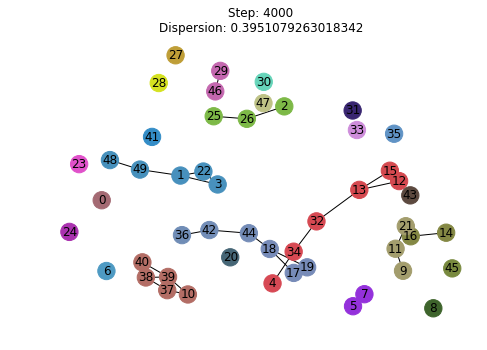

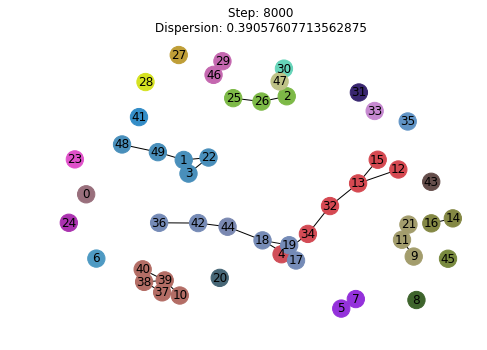

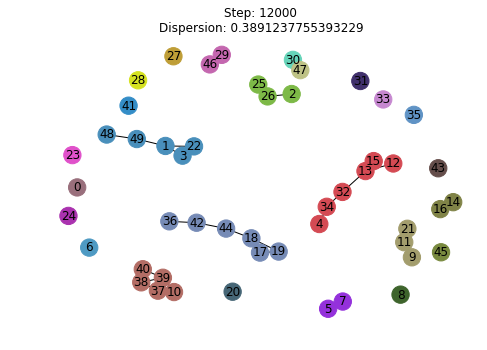

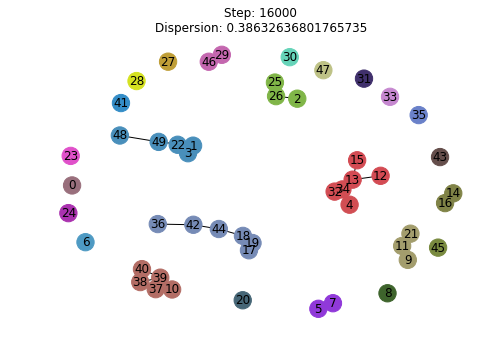

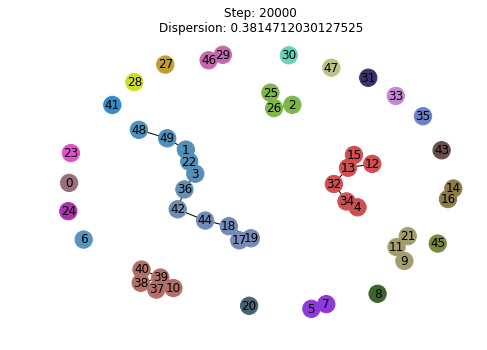

In [1230]:
sim = MultivarSocialDynamicsSimulation(alpha=0.075, beta=0.3, gamma=7.89,delta=7.5,correlated = 0.4, p_add = 0.001)
sim.initialize()

plt.figure()
sim.observe()
for i in range(5):
    for i in range(4000):
        sim.update()
    sim.observe()

    plt.show()

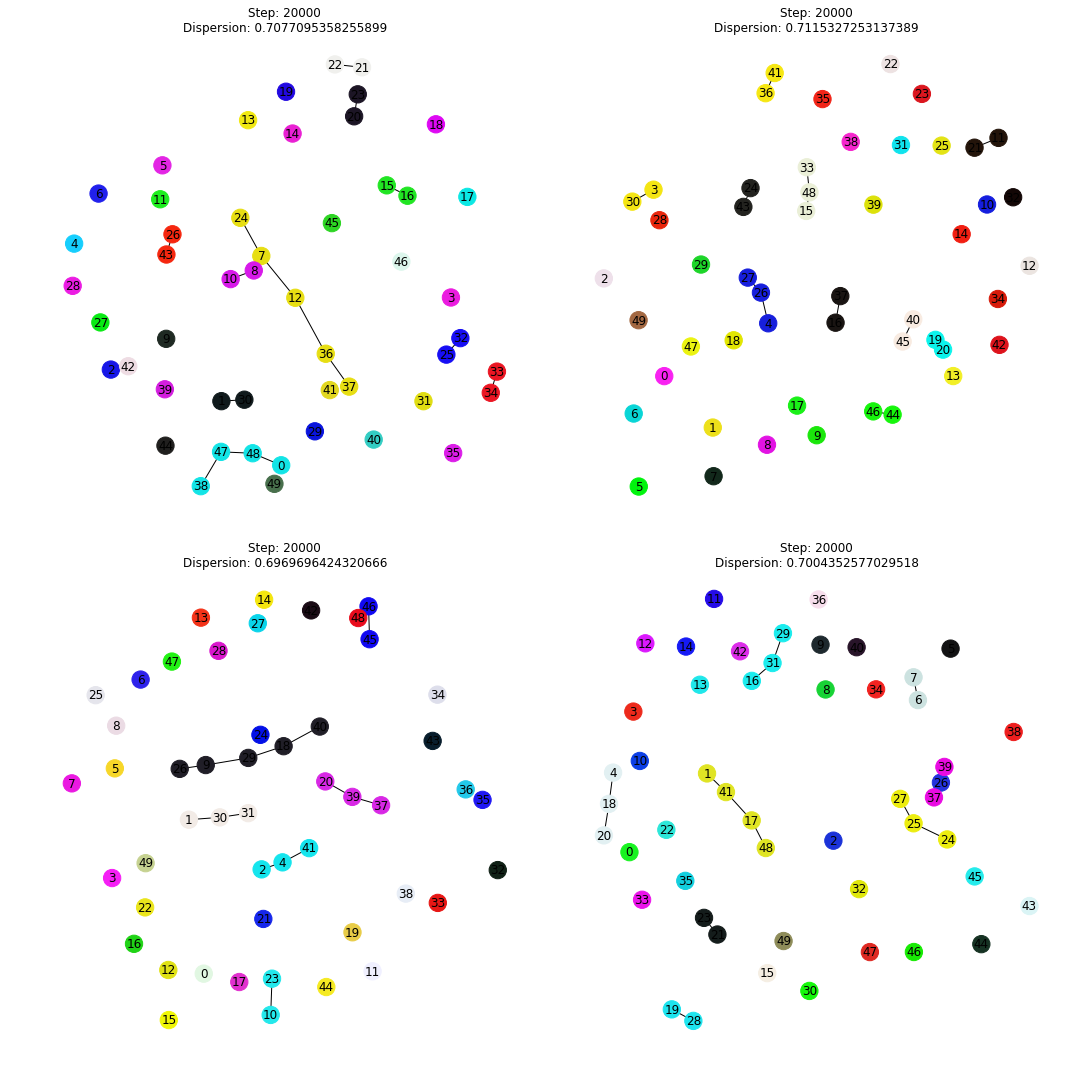

In [1432]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

for i,ax in enumerate(axes.flatten()):
    sim = MultivarSocialDynamicsSimulation(alpha=0.075, beta=0.3, gamma=7.89,delta=7.5,correlated = 0.4, p_add = 0.001)
    sim.initialize()

    for i in range(20000):
        sim.update()
    #plt.figure()
    sim.observe_custom(ax)


plt.tight_layout()
plt.show()


While the number of connected components with three nodes or more is higher than in both attractors, most elements cannot find a group they can belong to.  However, we can visually observe that there are several nodes that could easily group together, but are not having the opportunity to get to know each other. I will test the effect of increasing the probability of creating a new edge on the structural metrics plotted above.

Probability of adding a new edge: 0.005


/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:199: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in double_scalars


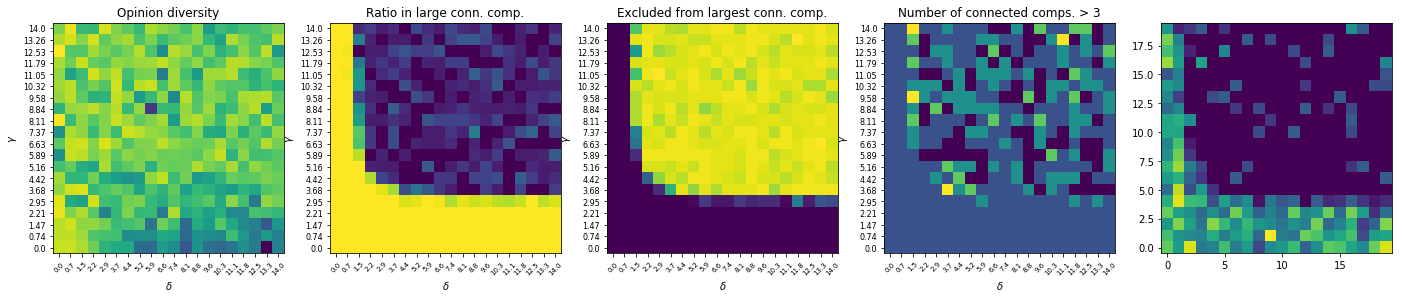

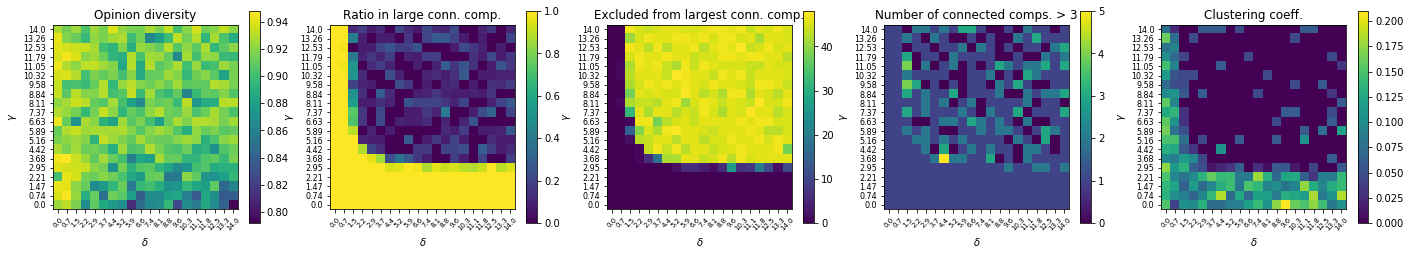

Probability of adding a new edge: 0.1


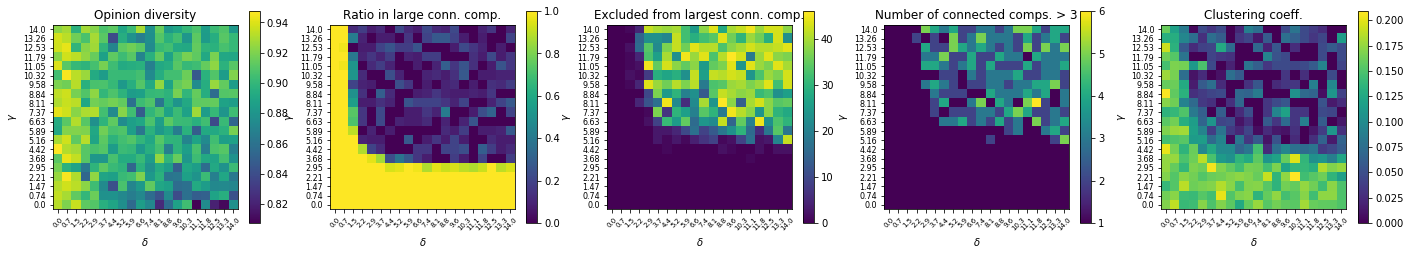

Probability of adding a new edge: 0.2


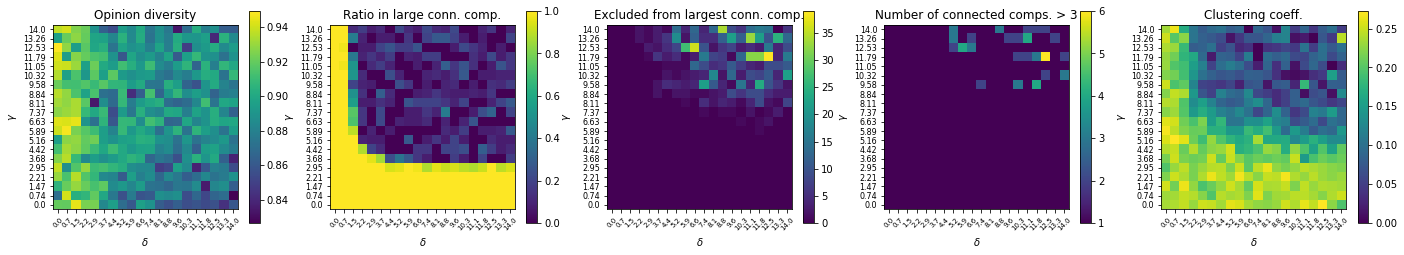

Probability of adding a new edge: 0.3


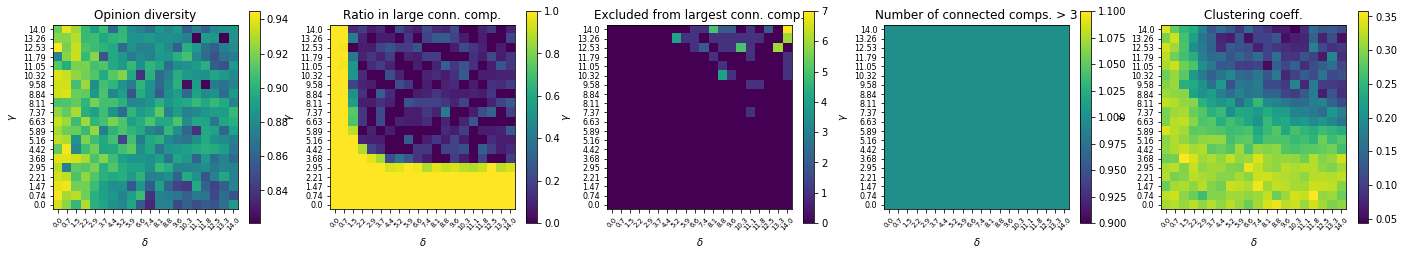

In [1479]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
padds = [0.005, 0.1, 0.2, 0.3]
correl=0.9

for k,p in enumerate(padds):
    print('Probability of adding a new edge: '+str(p))
    dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
    largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
    avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
    nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
    clus = np.zeros((gammas.shape[0],deltas.shape[0]))

    for i,g in enumerate(gammas):
            for j,d in enumerate(deltas):
                sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,
                                                       network_size=50, only_most_agreed = True,
                                                       normal_sampling = False, p_add = p)
                sim.initialize()
                for _ in range(1000):
                    sim.update()

                try:
                    dispersions[i,j] = sim.dispersion()
                except:
                    dispersions[i,j] = 0

                largest_components[i,j] = sim.len_out_largest_comp()
                avgdegs[i,j] = sim.average_degree()
                nlcs[i,j] = sim.n_large_connected_components()
                clus[i,j] = nx.average_clustering(sim.graph)

            #print('{}% done'.format(str((i+1)*100/len(gammas))[:3]))

    metrics = np.array([dispersions, in_large_comp, largest_components,nlcs,clus])
    titles = ['Opinion diversity', 'Ratio in large conn. comp.', 'Excluded from largest conn. comp.', 'Number of connected comps. > 3', 'Clustering coeff.']
    imshows = ['','','','','']

    fig, axes = plt.subplots(1,5,figsize=(24,26))
    for i,ax in enumerate(axes.flatten()[:6]):
        imshows[i] = ax.imshow(metrics[i],origin='lower')
        ax.set_xticks(range(len(deltas)))
        ax.set_yticks(range(len(gammas)))

        ax.set_xlabel(r'$\delta$')
        ax.set_ylabel(r'$\gamma$')

        ax.set_title(titles[i])

        ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
        ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
    for i,ax in enumerate(axes.flatten()):
        plt.colorbar(imshows[i], ax=ax,shrink=0.15)

    # #plt.tight_layout()
    plt.show()




To find a a simulation where multiple clusters of different colors are formed and few nodes are left alone,
the optimal candidate set of parameters should follow the following conditions: 

* almost all nodes should be included in a large component (not blue on the first column)
* should have many elements excluded from the largest component, since we want competing clusters (not green on the second column)
* at least 4 large connected componets (green or green square on the third column)

There is no consistent set of parameters that fulfills these conditions.

However, a more realistic endeavor would be finding a set of parameters that creates a large connected component with high opinion diversity and low clustering, where smaller subcomponents would be more clustered and homogeneous, analogous to the empirical social networks of systems such as classrooms and work spaces. For this purpose, I will run a simulation with p = 0.03, with parameters such that the clustering coefficient is low (upper right in the last column).

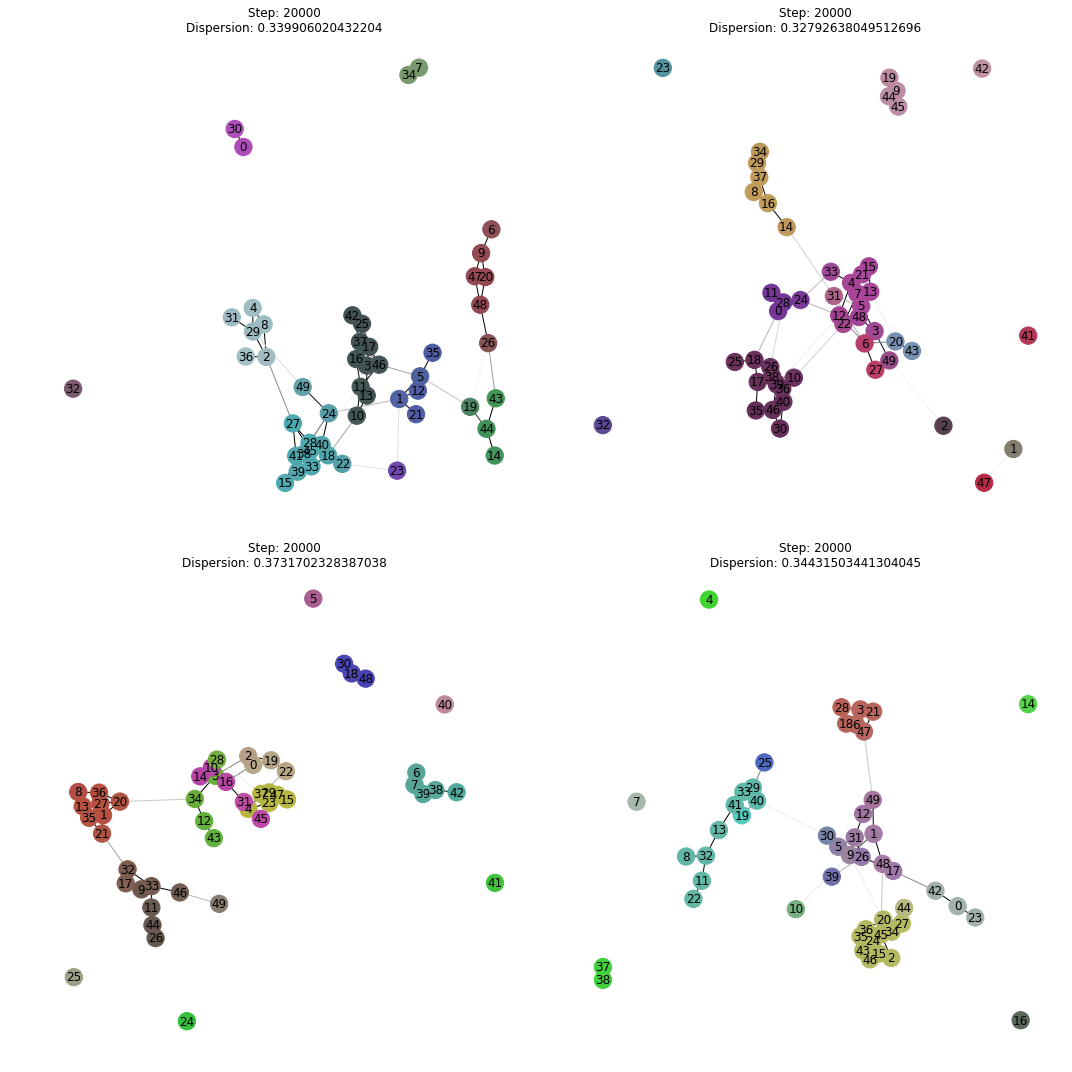

In [1496]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

for i,ax in enumerate(axes.flatten()):
    sim = MultivarSocialDynamicsSimulation(alpha=0.075, beta=0.3, gamma=11,delta=10,correlated = 0.4, p_add = 0.02)
    #sim = MultivarSocialDynamicsSimulation(alpha=0.075, beta=0.3, gamma=11.5,delta=1.5,correlated = 0.4, p_add = 0.02)
    sim.initialize()

    for i in range(20000):
        sim.update()
    #plt.figure()
    sim.observe_custom(ax, layout='spring')


plt.tight_layout()
plt.show()



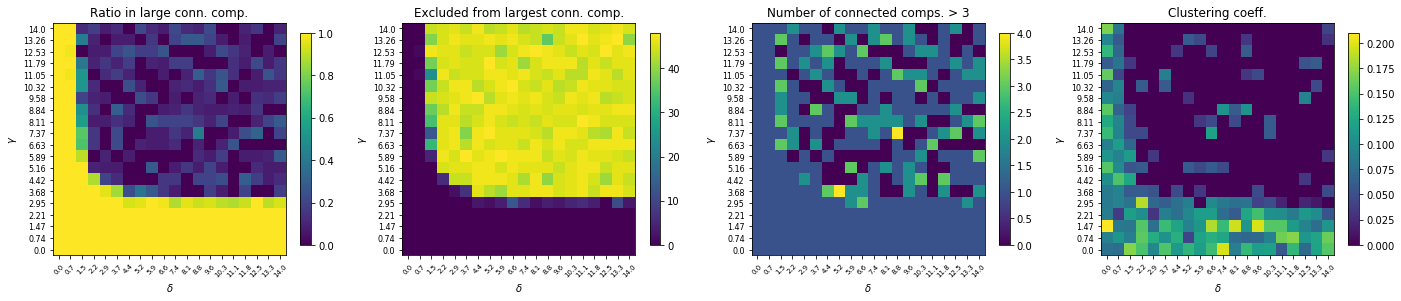

In [1456]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
correl=0.9

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
clus = np.zeros((gammas.shape[0],deltas.shape[0]))
in_large_comp = np.zeros((gammas.shape[0],deltas.shape[0]))



for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,
                                                   network_size=50, only_most_agreed = True,
                                                   normal_sampling = True)
            sim.initialize()
            for _ in range(1000):
                sim.update()
                
            try:
                dispersions[i,j] = sim.dispersion()
            except:
                dispersions[i,j] = 0
            
            largest_components[i,j] = sim.len_out_largest_comp()
            in_large_comp[i,j] = sim.in_large_conn_component()
            avgdegs[i,j] = sim.average_degree()
            nlcs[i,j] = sim.n_large_connected_components()
            clus[i,j] = nx.average_clustering(sim.graph)
        
        print('{}% done'.format(str((i+1)*100/len(gammas))[:3]))

metrics = np.array([in_large_comp, largest_components,nlcs,clus])
titles = ['Ratio in large conn. comp.', 'Excluded from largest conn. comp.', 'Number of connected comps. > 3', 'Clustering coeff.']
imshows = ['','','','']

fig, axes = plt.subplots(1,4,figsize=(24,26))
for i,ax in enumerate(axes.flatten()[:6]):
    imshows[i] = ax.imshow(metrics[i],origin='lower')
    ax.set_xticks(range(len(deltas)))
    ax.set_yticks(range(len(gammas)))
    
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\gamma$')
    
    ax.set_title(titles[i])
    
    ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
    ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
for i,ax in enumerate(axes.flatten()):
    plt.colorbar(imshows[i], ax=ax,shrink=0.15)

# #plt.tight_layout()
plt.show()




As it can be observed in the plot above,

In [1194]:
gammas = np.linspace(0,10,10)
deltas = np.linspace(0,10,10)
correl = np.linspace(0,0.9,10)

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))

fig, axes = plt.subplots(2,5,figsize=(15,10))

for k,ax in enumerate(axes.flatten()):
    start = time.time()
    for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = SocialDynamicsSimulation(gamma=g,delta=d,correlated=correl[k])
            sim.initialize()
            for _ in range(10000):
                sim.update()
            dispersions[i,j] = sim.dispersion()
    
    
    ax.imshow(dispersions,origin='lower',vmin=0,vmax=0.8)
    ax.set_xticks(range(0,10,1))
    ax.set_yticks(range(0,10,1))
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(r'$\delta$')
    ax.set_title('Correlation between variables: {}'.format(str(correl[k])[:3]),fontsize=8)
    
    print('Colormap runtime: {}'.format(time.time()-start))
#plt.tight_layout()
plt.subplots_adjust(hspace=-0.45,wspace=0.3)#0.01,0.4,0.1,0.5)
#plt.colorbar(plt.imshow(dispersions,vmin=0,vmax=0.8))
plt.show()




#plt.colorbar()


/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

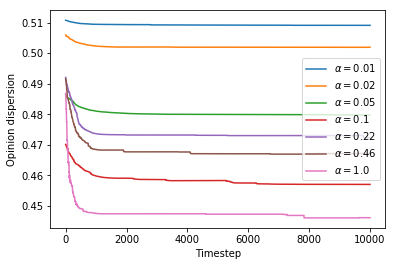

In [1064]:
alphas = np.logspace(-2,0,7)

dispersions = np.zeros((7,10000))

for i,a in enumerate(alphas):
    sim = SocialDynamicsSimulation(alpha=a,gamma=g,delta=d,correlated=correl)
    sim.initialize()
    for _ in range(10000):
        sim.update()
        dispersions[i,_] = sim.dispersion()

for d in range(7):
    plt.plot(dispersions[d],label=r'$\alpha={}$'.format(round(alphas[d],2)))
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Opinion dispersion')
#plt.yscale('log')
plt.show()



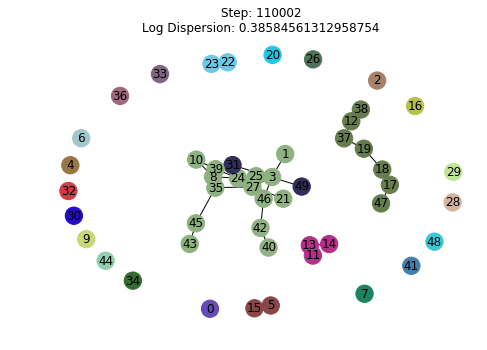

In [942]:
for _ in range(50000):
    sim.update()
sim.observe()
plt.show()

In [1089]:
gammas = np.linspace(0,6,10)
deltas = np.linspace(0,2,10)

sim = SocialDynamicsSimulation(delta=5,gamma=5,network_size=2)
sim.initialize()

sim.graph.edges()



EdgeView([(0, 1)])

In [67]:
?np.random.sample(g.nodes)

In [557]:
g = nx.random_graphs.binomial_graph(n=8,p=0.2)
for node in g.nodes:
        g.nodes[node]['opinion'] = np.random.random(3)
        
np.linalg.det(np.cov(np.array([g.nodes[x]['opinion'] for x in g.nodes]), rowvar=False))

0.000766962990931742

In [31]:
np.random.choice(g.edges)

ValueError: a must be 1-dimensional

In [116]:

[g.degree[n] for n in g.nodes]

[1, 2, 2, 0, 1, 1, 3, 2]

In [326]:
cn = np.zeros((len(g.nodes),len(g.nodes)))
dm = np.zeros((len(g.nodes),len(g.nodes)))
for i,m in enumerate(g.nodes):
    for j,n in enumerate(g.nodes):
        cn[i,j] = len(list(nx.common_neighbors(g,m,n)))
        try:
            dm[i,j] = nx.shortest_path_length(g,m,n) if nx.shortest_path_length(g,m,n)!= 0 else np.nan
        except:
            dm[i,j]= np.inf
        
    

def sample_new_edge(g):
    n_nodes = g.number_of_nodes()
    cn = np.zeros((n_nodes,n_nodes)) #matrix of common neighbors
    dm = np.zeros((n_nodes,n_nodes)) #matrix of distances
    
    for i,m in enumerate(g.nodes):
        for j,n in enumerate(g.nodes):
            #return the number of common neighbors between two nodes
            cn[i,j] = len(list(nx.common_neighbors(g,m,n)))
            try:
                # if distance is zero, return NaN (we don't want self-edges)
                dm[i,j] = nx.shortest_path_length(g,m,n) if nx.shortest_path_length(g,m,n)!= 0 else np.nan
            except:
                # if there is no shortest path, distance is infinite
                dm[i,j]= np.inf
    
    #matrix of sampling probabilities
    samp_probs = np.zeros(cn.shape)
    
    #for each cell of the matrix
    for i in itertools.product(range(n_nodes),range(n_nodes)):
        
        
        # set the probability of creating an edge between two nodes of a connected component
        # as (c+1)/(d-1).
        # set the probability of creating an existing edge (d=1) as nan
        samp_probs[i] = (cn[i]+1)*(1/1)/(dm[i]-1) if (cn[i]+1)/(dm[i]-1) != np.inf else np.nan
    
    smallest_prob = min([n for n in np.unique(samp_probs) if n > 0])
    
    for i in itertools.product(range(n_nodes),range(n_nodes)):
        if samp_probs[i] == 0:
            samp_probs[i] = smallest_prob/2
            #samp_probs = samp_probs#/np.nansum(samp_probs)*0.9
    samp_probs = samp_probs/np.nansum(samp_probs)*2
    
    #print(samp_probs)
    
    samp_df = pd.DataFrame([(c,samp_probs[c]) for c in itertools.combinations_with_replacement(range(n_nodes),2) if not np.isnan(samp_probs[c])])
    
    samp_roulette = np.cumsum(samp_df.iloc[:,1])
    sampled_edge = samp_df.iloc[samp_roulette.searchsorted(np.random.uniform(0, 1))[0],0]
    
    return sampled_edge
print(sample_new_edge(g))
#print(np.sum(sp(cn,dm).iloc[:,1]))

#list(zip(np.where(sp(cn,dm)==0)[0],np.where(sp(cn,dm)==0)[1]))

(1, 6)


/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


In [331]:
[g.degree[n] for n in g.nodes]

#disconnected = [c for c in itertools.combinations_with_replacement(range(n_nodes),2) if sp(cn,dm)[c]== 0]
#[n for n in sp(cn,dm)]
#min([n for n in sp(cn,dm) if n>0])
#list(np.filter(lambda x: x>0, sp(cn,dm)))

#len(list(nx.common_neighbors(g,list(g.nodes)[0],list(g.nodes)[1])))

[1, 2, 2, 0, 1, 1, 3, 2]

In [170]:
gx = np.zeros((4,4))


for i in itertools.product(range(gx.shape[0]),range(gx.shape[1])):
    print(gx[i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [430]:
exp_acceptance(,3)

0.4641588833612779

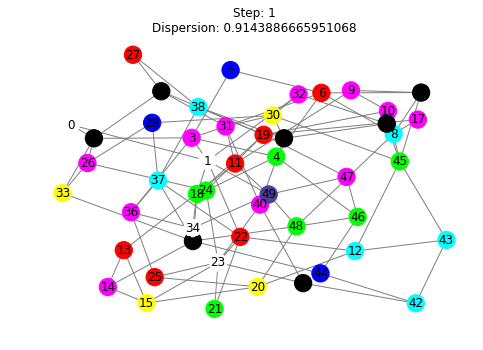

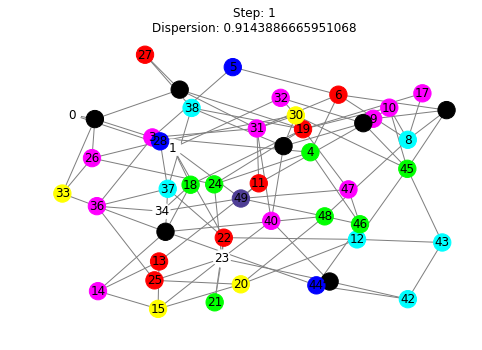

In [1393]:
sim = MultivarSocialDynamicsSimulation(network_size=50)
sim.initialize()
sim.update()
fig, axes = plt.subplots(2,2)# , axes = plt.subplots(2,2)

#for ax in axes.flatten():
sim.observe()
plt.show()
sim.observe()
plt.show()



6.643856189774725

In [625]:
np.matmul(np.array([1,2,3]),np.array([1,0,0]))

1

In [639]:
nx.cluster.average_clustering(sim.graph)

0.028666666666666663

In [746]:
?np.logical_or(p<0)

array([[1.63821944, 1.20961285, 1.24867497]])

In [860]:
meanm = [0.5,0.5,0.5]
cov_ij = 0.5*0.3
covm = np.array([[1,cov_ij,cov_ij],
                [cov_ij,1,cov_ij],
                [cov_ij,cov_ij,1]])

#p = np.array([-1,-2,-3])

np.random.multivariate_normal(mean=[0.5,0.5,0.5],cov=covm,size=1)[0]



array([-0.41686798,  0.35308418, -1.92307986])

True

In [741]:
any(n < 0 for n in p)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [761]:
p

array([[-0.98828515, -0.1845568 , -0.78668925]])

In [762]:
p[0]

array([-0.98828515, -0.1845568 , -0.78668925])

In [789]:
np.linspace(0,10,100).shape[0]

100

In [898]:
str(np.linspace(0,0.9,10)[6])[:4]

'0.60'

[0.0, 0.44, 0.89, 1.33, 1.78, 2.22, 2.67, 3.11, 3.56, 4.0]

In [1065]:
d

6

In [1364]:
plt

<module 'matplotlib.pyplot' from '/Users/nico/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [1262]:
np.random.randint(0, 1)

0

In [1263]:
np.random.randint(0, 1)

0

In [1264]:
np.random.randint(0, 1)

0

In [1276]:
np.random.randint(0, 2)

0

In [1269]:
np.random.randint(0, 1)
np.random.randint(0, 1)

0

In [1402]:
ne = nx.complete_graph(5)

0
1
2
3


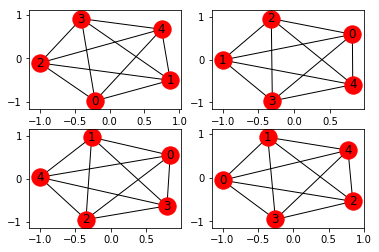

In [1418]:
fig, axes = plt.subplots(2,2)

for i,ax in enumerate(axes.flatten()):
    print(i)
    nx.draw_networkx(ne,ax=ax)

plt.show()



In [1441]:
[0.001, 0.005, 0.1, 0.15,0.2]

13